# Wet vegetation, four ways

This notebook investigates four different ways of masking wet vegetation which all follow the same general idea (threshold TCW and TCG) but change the order of the steps.

In [187]:
import asyncio
from time import time
import itertools

import contextily as ctx
import ipywidgets
import matplotlib.pyplot as plt
import numpy as np
import xarray
import datacube
from tqdm.notebook import tqdm
import sklearn.metrics
import scipy.optimize as opt

import sys
sys.path.insert(1, '../Scripts')
import dea_bandindices
import dea_plotting

Set these parameters to change the plots at the end:

In [2]:
tile = '17,-39'
# xlim = 1.70e6, 1.74e6
# ylim = -3.84e6, -3.80e6

xlim = 1.70e6, 1.72e6
ylim = -3.82e6, -3.80e6

# Set the limits to None to show the whole tile.
# xlim = None
# ylim = None

## Load data

In [3]:
dc = datacube.Datacube(app='wet-veg-four-ways')

In [59]:
def get_tcw_percentiles(tile_label):
    tif_path_base = "/g/data/r78/datacube_stats/TCW_stats/demo_tiles/gabrielle_workspace/output/LS_TCW_PC_{}_1986_2020_summary.tif"
    tif_path = tif_path_base.format(tile_label.replace(",", "_"))
    da = xarray.open_rasterio(tif_path)
    return da

def get_tcg_percentiles(tile_label):
    tif_path_base = "/g/data/r78/datacube_stats/TCW_stats/demo_tiles/gabrielle_workspace/output/LS_TCG_PC_{}_1986_2020_summary.tif"
    tif_path = tif_path_base.format(tile_label.replace(",", "_"))
    da = xarray.open_rasterio(tif_path)
    return da

def get_sr(da):
    return dc.load('ls8_nbart_albers', time='2019', geopolygon=datacube.utils.geometry.Geometry(da.geobox.extent),
                   measurements=['blue', 'green', 'red', 'nir', 'swir1', 'swir2'], group_by='solar_day')

def get_gm(da):
    return dc.load('ls8_nbart_geomedian_annual', time='2019', geopolygon=datacube.utils.geometry.Geometry(da.geobox.extent))

In [5]:
tcw95 = get_tcw_percentiles(tile).sel(x=slice(*xlim), y=slice(*ylim[::-1])).isel(band=3)

In [6]:
tcg50 = get_tcg_percentiles(tile).sel(x=slice(*xlim), y=slice(*ylim[::-1])).isel(band=1)

In [60]:
sr = get_sr(tcg50)

In [8]:
gm = get_gm(tcg50).isel(time=0)

## Calculate TCG/TCW

In [146]:
dea_bandindices.calculate_indices(sr, index='TCG', collection='ga_ls_2', deep_copy=False, normalise=False)

<xarray.Dataset>
Dimensions:      (time: 46, x: 800, y: 800)
Coordinates:
  * time         (time) datetime64[ns] 2019-01-06T23:43:34.500000 ... 2019-12...
  * y            (y) float64 -3.8e+06 -3.8e+06 -3.8e+06 ... -3.82e+06 -3.82e+06
  * x            (x) float64 1.7e+06 1.7e+06 1.7e+06 ... 1.72e+06 1.72e+06
    spatial_ref  int32 3577
Data variables:
    blue         (time, y, x) int16 -999 -999 -999 -999 -999 ... 803 831 864 849
    green        (time, y, x) int16 -999 -999 -999 -999 -999 ... 882 929 933 932
    red          (time, y, x) int16 -999 -999 -999 -999 ... 909 1001 1030 1034
    nir          (time, y, x) int16 -999 -999 -999 -999 ... 2184 2258 2147 2166
    swir1        (time, y, x) int16 -999 -999 -999 -999 ... 2261 2546 2584 2642
    swir2        (time, y, x) int16 -999 -999 -999 -999 ... 1316 1581 1627 1673
    TCG          (time, y, x) float64 286.1 286.1 286.1 ... 674.7 559.2 568.4
    TCW          (time, y, x) float64 587.7 587.7 ... -1.875e+03 -1.939e+03
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

In [147]:
dea_bandindices.calculate_indices(gm, index='TCG', collection='ga_ls_2', deep_copy=False, normalise=False)

<xarray.Dataset>
Dimensions:      (x: 800, y: 800)
Coordinates:
    time         datetime64[ns] 2019-01-01
  * y            (y) float64 -3.8e+06 -3.8e+06 -3.8e+06 ... -3.82e+06 -3.82e+06
  * x            (x) float64 1.7e+06 1.7e+06 1.7e+06 ... 1.72e+06 1.72e+06
    spatial_ref  int32 3577
Data variables:
    blue         (y, x) int16 128 150 128 127 110 106 ... 350 375 416 387 442
    green        (y, x) int16 225 224 210 219 191 185 ... 500 538 588 566 633
    red          (y, x) int16 223 224 224 235 194 147 ... 467 527 603 607 647
    nir          (y, x) int16 1973 1829 1860 1785 1700 ... 2358 2368 2258 2376
    swir1        (y, x) int16 786 750 821 858 839 ... 1660 1836 2107 2062 2137
    swir2        (y, x) int16 316 316 354 354 346 285 ... 830 950 1164 1140 1192
    TCG          (y, x) float64 1.327e+03 1.209e+03 ... 1.107e+03 1.145e+03
    TCW          (y, x) float64 -294.8 -292.5 -362.6 ... -1.425e+03 -1.461e+03
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

In [145]:
dea_bandindices.calculate_indices(sr, index='TCW', collection='ga_ls_2', deep_copy=False, normalise=False)

<xarray.Dataset>
Dimensions:      (time: 46, x: 800, y: 800)
Coordinates:
  * time         (time) datetime64[ns] 2019-01-06T23:43:34.500000 ... 2019-12...
  * y            (y) float64 -3.8e+06 -3.8e+06 -3.8e+06 ... -3.82e+06 -3.82e+06
  * x            (x) float64 1.7e+06 1.7e+06 1.7e+06 ... 1.72e+06 1.72e+06
    spatial_ref  int32 3577
Data variables:
    blue         (time, y, x) int16 -999 -999 -999 -999 -999 ... 803 831 864 849
    green        (time, y, x) int16 -999 -999 -999 -999 -999 ... 882 929 933 932
    red          (time, y, x) int16 -999 -999 -999 -999 ... 909 1001 1030 1034
    nir          (time, y, x) int16 -999 -999 -999 -999 ... 2184 2258 2147 2166
    swir1        (time, y, x) int16 -999 -999 -999 -999 ... 2261 2546 2584 2642
    swir2        (time, y, x) int16 -999 -999 -999 -999 ... 1316 1581 1627 1673
    TCG          (time, y, x) float64 0.02861 0.02861 ... 0.05592 0.05684
    TCW          (time, y, x) float64 587.7 587.7 ... -1.875e+03 -1.939e+03
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

In [142]:
dea_bandindices.calculate_indices(gm, index='TCW', collection='ga_ls_2', deep_copy=False, normalise=False)

../Scripts/dea_bandindices.py:270: UserWarning: 
A coefficient-based index ('TCW') normally applied to surface reflectance values in the 
0.0-1.0 range was applied to values in the 0-10000 range. This can produce unexpected results; 
if required, resolve this by setting `normalise=True`
  warnings.warn(f"\nA coefficient-based index ('{index}') normally "


<xarray.Dataset>
Dimensions:      (x: 800, y: 800)
Coordinates:
    time         datetime64[ns] 2019-01-01
  * y            (y) float64 -3.8e+06 -3.8e+06 -3.8e+06 ... -3.82e+06 -3.82e+06
  * x            (x) float64 1.7e+06 1.7e+06 1.7e+06 ... 1.72e+06 1.72e+06
    spatial_ref  int32 3577
Data variables:
    blue         (y, x) int16 128 150 128 127 110 106 ... 350 375 416 387 442
    green        (y, x) int16 225 224 210 219 191 185 ... 500 538 588 566 633
    red          (y, x) int16 223 224 224 235 194 147 ... 467 527 603 607 647
    nir          (y, x) int16 1973 1829 1860 1785 1700 ... 2358 2368 2258 2376
    swir1        (y, x) int16 786 750 821 858 839 ... 1660 1836 2107 2062 2137
    swir2        (y, x) int16 316 316 354 354 346 285 ... 830 950 1164 1140 1192
    TCG          (y, x) float64 0.1327 0.1209 0.1235 ... 0.1181 0.1107 0.1145
    TCW          (y, x) float64 -294.8 -292.5 -362.6 ... -1.425e+03 -1.461e+03
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

## Calculate wet vegetation index

The four ways are as follows.

1. "Gabrielle's Percentile Method" (GPM): TCG50 < 1000 and TCW95 > -600.

2. "Daily Percentiles" (DP): Daily TCG < 1000 and daily TCW > -600, then take the nth percentile.
    
3. "Daily Double Threshold" (DDT): Daily TCG < 1000, daily TCW > -600, and generate percentiles of both. Then threshold _those_ and take a percentile.

4. "Bex's Geomedian Method" (BGM): TCG < 1000 and TCW > -600 for the geomedian.

In [15]:
def plot_mask(mask, cmap='Greys_r', ax=None, **kwargs):
    
    if ax is None:
        ax = plt.gca()
    mask.plot.imshow(interpolation='gaussian', cmap=cmap, ax=ax, **kwargs)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

In [106]:
tcw_thresh = -350
tcg_thresh = 1000

### Gabrielle's Percentile Method

In [107]:
gpm = (tcw95 > tcw_thresh) & (tcg50 < tcg_thresh)

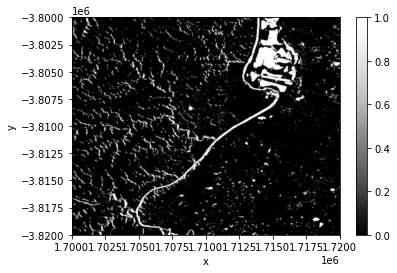

In [108]:
plot_mask(gpm)

### Daily percentiles

In [148]:
def daily_percentiles(params):
    tcw_thresh, tcg_thresh, wetveg_thresh = params
    return (((sr.TCW > tcw_thresh) & (sr.TCG < tcg_thresh)).mean(axis=0) > wetveg_thresh)

def daily_percentiles_cost(params):
    guess = daily_percentiles(params).values.ravel()
    cost = np.sqrt(((guess.astype(float) - gpm.astype(float).values.ravel()) ** 2).sum()) / 2
    return cost

In [202]:
def _just_mean(params):
    tcw_thresh, tcg_thresh, wetveg_thresh = params
    return (((sr.TCW > tcw_thresh) & (sr.TCG < tcg_thresh)).mean(axis=0))

In [149]:
threshs = opt.fmin(daily_percentiles_cost, [tcw_thresh, tcg_thresh, 0.5])

Optimization terminated successfully.
         Current function value: 99.653148
         Iterations: 85
         Function evaluations: 194


In [206]:
mean = _just_mean([-350, 1000, 0])

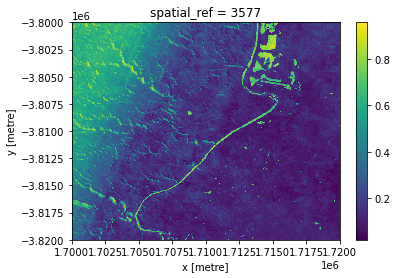

In [209]:
(mean).plot()

In [150]:
dp = daily_percentiles(threshs)

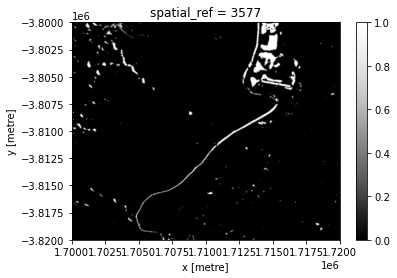

In [152]:
plot_mask(dp)

In [198]:
threshs

array([-6.59949602e+02,  4.09169753e+02,  6.54935707e-01])

### Daily double threshold

In [153]:
def daily_double_threshold(params):
    tcw_thresh, tcg_thresh, tcw_thresh2, tcg_thresh2 = params
    tcw_thresholded = (sr.TCW > tcw_thresh).mean(axis=0)
    tcg_thresholded = (sr.TCG < tcg_thresh).mean(axis=0)
    return (tcw_thresholded > tcw_thresh2) & (tcg_thresholded > tcg_thresh2)  # the above < flips the sign

def daily_double_threshold_cost(params):
    guess = daily_double_threshold(params).values.ravel()
    cost = np.sqrt(((guess.astype(float) - gpm.astype(float).values.ravel()) ** 2).sum()) / 2
    return cost

In [154]:
threshs_ddt = opt.fmin(daily_double_threshold_cost, [tcw_thresh, tcg_thresh, 0.5, 0.5])

Optimization terminated successfully.
         Current function value: 93.131627
         Iterations: 93
         Function evaluations: 214


In [155]:
ddt = daily_double_threshold(threshs_ddt)

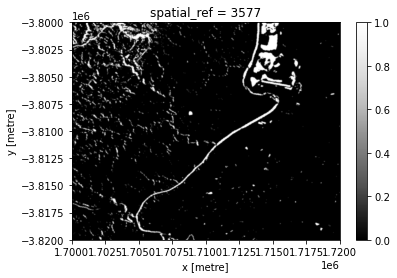

In [156]:
plot_mask(ddt)

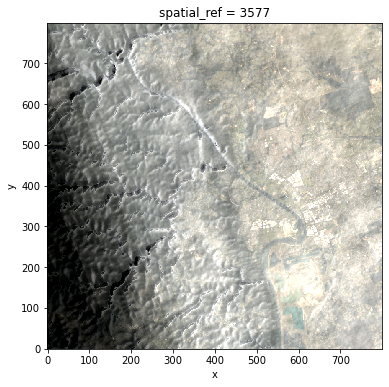

In [174]:
dea_plotting.rgb(sr.mean(axis=0), bands=['red', 'green', 'blue'])

### Bex's Geomedian Method

In [158]:
def geomedian_method(params):
    tcw_thresh, tcg_thresh = params
    return (gm.TCW > tcw_thresh) & (gm.TCG < tcg_thresh)

def geomedian_method_cost(params):
    guess = geomedian_method(params).values.ravel()
    cost = np.sqrt(((guess.astype(float) - gpm.astype(float).values.ravel()) ** 2).sum()) / 2
    return cost

In [159]:
thresh_bgm = opt.fmin(geomedian_method_cost, [tcw_thresh, tcg_thresh])

Optimization terminated successfully.
         Current function value: 81.057079
         Iterations: 42
         Function evaluations: 103


In [160]:
bgm = geomedian_method(thresh_bgm)

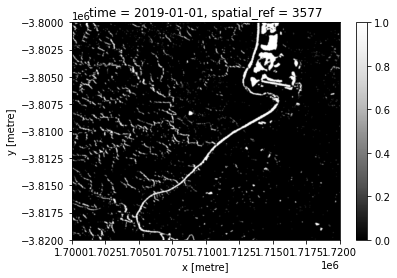

In [161]:
plot_mask(bgm)

In [196]:
del bgm.time.attrs['units']

In [197]:
gpm.to_netcdf('gpm.nc')
dp.to_netcdf('dp.nc')
ddt.to_netcdf('ddt.nc')
bgm.to_netcdf('bgm.nc')

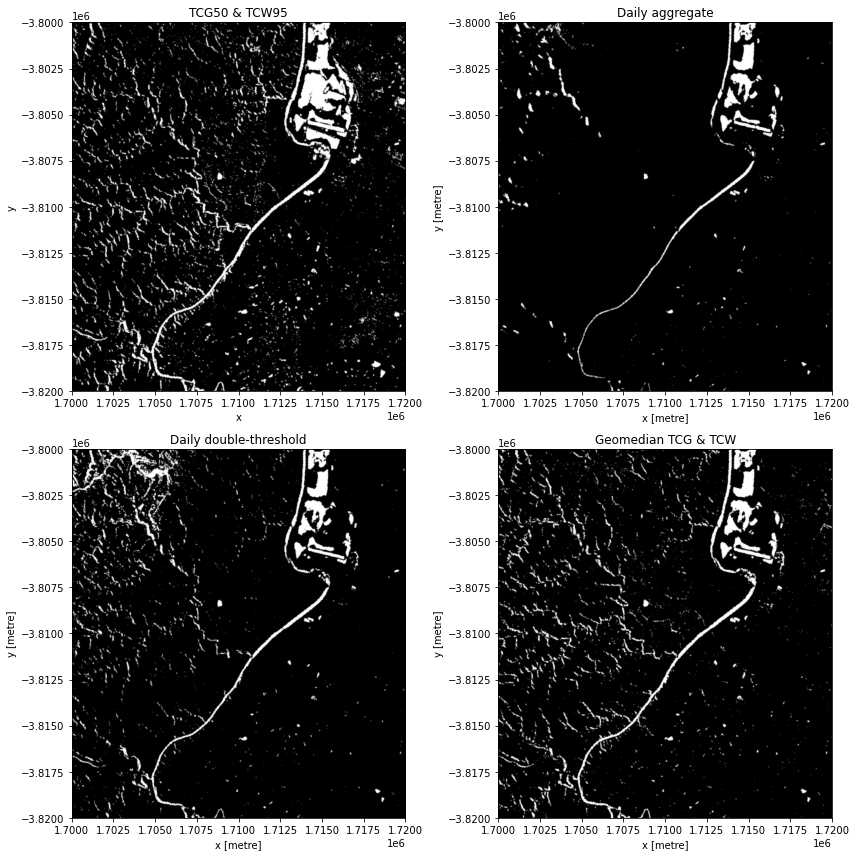

In [170]:
fig, ((a, b), (c, d)) = plt.subplots(2, 2, figsize=(12, 12))
plot_mask(gpm, ax=a, add_colorbar=False)
a.set_title('TCG50 & TCW95')
plot_mask(dp, ax=b, add_colorbar=False)
b.set_title('Daily aggregate')
plot_mask(ddt, ax=c, add_colorbar=False)
c.set_title('Daily double-threshold')
plot_mask(bgm, ax=d, add_colorbar=False)
d.set_title('Geomedian TCG & TCW')
plt.tight_layout()
plt.show()

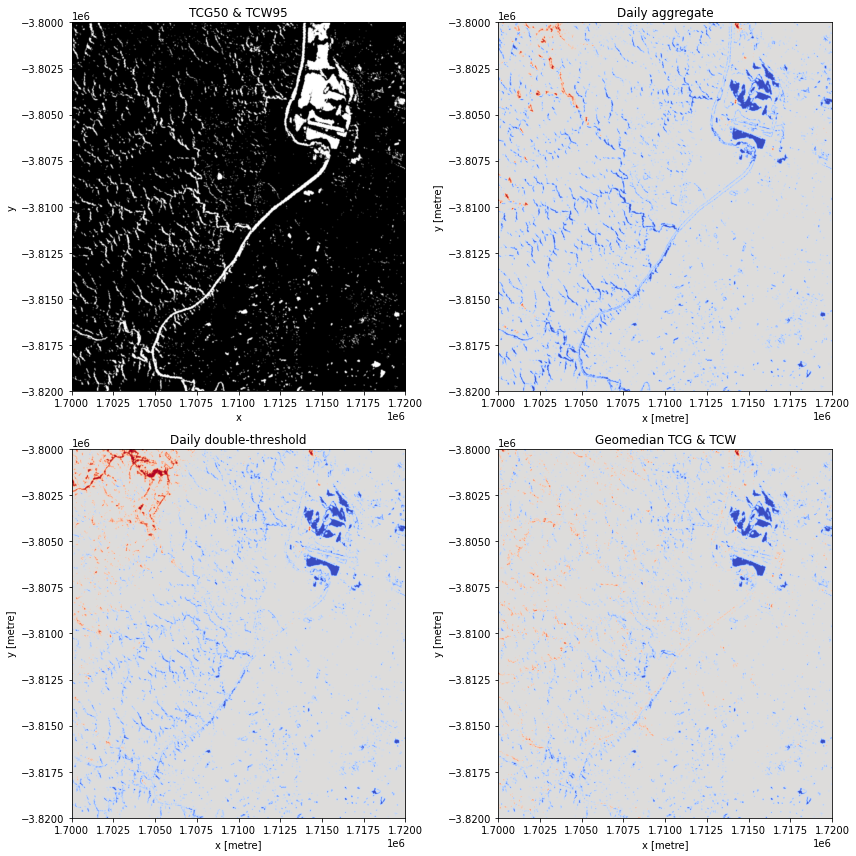

In [171]:
fig, ((a, b), (c, d)) = plt.subplots(2, 2, figsize=(12, 12))
plot_mask(gpm, ax=a, add_colorbar=False)
a.set_title('TCG50 & TCW95')
plot_mask(dp.astype(float) - gpm.astype(float), ax=b, add_colorbar=False, cmap='coolwarm', vmin=-1, vmax=1)
b.set_title('Daily aggregate')
plot_mask(ddt.astype(float) - gpm.astype(float), ax=c, add_colorbar=False, cmap='coolwarm', vmin=-1, vmax=1)
c.set_title('Daily double-threshold')
plot_mask(bgm.astype(float) - gpm.astype(float), ax=d, add_colorbar=False, cmap='coolwarm', vmin=-1, vmax=1)
d.set_title('Geomedian TCG & TCW')
plt.tight_layout()
plt.show()

In [176]:
pip install richdem

Unload all python modules, if you experience any issues.
Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 4.5 MB 4.3 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [184]:
import richdem as rd
def xr_terrain(da, attribute=None):
    """
    Using the richdem package, calculates terrain attributes
    on a DEM stored in memory as an xarray.DataArray
    Params
    -------
    da : xr.DataArray
    attribute : str
        One of the terrain attributes that richdem.TerrainAttribute()
        has implemented. e.g. 'slope_riserun', 'slope_percentage', 'aspect'.
        See all option here:
        https://richdem.readthedocs.io/en/latest/python_api.html#richdem.TerrainAttribute
    """
    #remove time if its there
    da = da.squeeze()
    #convert to richdem array
    rda = rd.rdarray(da.data, no_data=da.attrs['nodata'])
    #add projection and geotransform
    rda.projection=pyproj.crs.CRS(da.attrs['crs']).to_wkt()
    rda.geotransform = da.geobox.affine.to_gdal()
    #calulate attribute
    attrs = rd.TerrainAttribute(rda, attrib=attribute)
    #return as xarray DataArray
    return xr.DataArray(attrs,
                        attrs=da.attrs,
                        coords={'x':da.x, 'y':da.y},
                        dims=['y', 'x'])

# Load DEM data
bounds = get_tile_bounds(tile)
slope = dem.dem #no elevation
slope = xr_terrain(slope, 'slope_riserun')
slope = slope.to_dataset(name='slope')
steep = slope > 0.1
print('steep.slope',steep.slope)

NameError: name 'get_tile_bounds' is not defined

In [186]:
dem = dc.load(product='srtm_dem1sv1_0',
            geopolygon=datacube.utils.geometry.Geometry(sr.geobox.extent),
            output_crs = 'EPSG:3577',
            resolution=(-25, 25)).squeeze()

Error opening source dataset: /g/data/rr1/Elevation/1secSRTM_DEMs_v1.0/DEM/Mosaic/dem1sv1_0


RasterioIOError: /g/data/rr1/Elevation/1secSRTM_DEMs_v1.0/DEM/Mosaic/dem1sv1_0: Permission denied